# CEO-REQUEST CHALLENGE

***CEO Question***

How do we increase customer satisfaction (so as to increase profit margins) while maintaining a healthy order volume?

**Findings from our Preliminary Analysis of the Orders and Sellers Datasets**

- The more sellers (`number_of_sellers`) and products (`number_of_products`) that are combined into a single order, the lower the order `review_score`.  
- The `wait_time` for the order, which is made up of two components (seller's `delay_to_carrier` + `carrier_delivery_time`) also has a significant association with low review scores.  

While orders that contain more than a single seller or product do have a significant association with low review scores, orders that contain multiple sellers do not make up a large portion of orders on the platform, so any policy changes (e.g. restricting orders to a single seller) would not have a large impact on the bottom line. 

Instead, we'll see if we can make improvements based on the second finding of low review scores associated with `wait_time`. Since `carrier_delivery_time` is less directly in our control, we'll identify sellers who have been receiving low review scores and see the impact on Olist's profits if we remove them. 

In this notebook, we'll quantify the impact of keeping these poor-performing sellers on the platform, and make specific recommendations to the CEO on what changes can be made in the short term to increase customer satisfaction and Olist profit margins. 

**Next Steps to our Analysis**
1. Identify how much revenue each seller brings in
2. Calculate the cost to Olist of bad reviews for each seller
3. Calculate the profit to Olist per seller and see the distribution 
3. Understand the impact on Olist's profits by poor performers
4. Find out how much removing these sellers would impact Olist's IT costs 


**Problem statement** ---REMOVE

To analyse the impact of removing the worst sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin




Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 



# START

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from olist.seller import Seller
from olist.data import Olist 

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Let's look again at our Sellers data
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99


In [3]:
#CAN BE DELETED LATER
#export dataset for Tableau
path = '../data/csv/seller_dataset_modified.csv'
sellers.to_csv(path_or_buf=path, index=False)

## Revenue per seller

Olist generates revenue from its sellers through two components:
1. **Monthly Membership Fee** - sellers pay Olist an **80 BRL** (~$15 USD) monthly fee to use the platform
2. **Revenue Share** - for every order on the platform, Olist takes a **10% cut** based on the product price  of each item (excl. shipping)


In [4]:
# Revenue Calculation: Monthly Membership Fee Calculation + Revenue Share

# Calculate total time on platform (in months)
number_of_months_on_olist = (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, 'M')
sellers['months_on_olist'] = number_of_months_on_olist.map(lambda x: 1 if x < 1 else np.ceil(x))

# Calculate total revenue seller generates for Olist
sellers['revenue_per_seller'] = sellers.months_on_olist * 80 + sellers.sales * 0.1
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales,revenue_per_seller
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799


## Costs per seller

Because poor reviews from customers can have several direct and indirect costs to a business (e.g. customer support utilization, bad word-of-mouth, low repeat rate, etc.), we'll use the following table to estimate monetary costs associated with bad reviews:

**Estimated cost to Olist per bad review (in Brazilian Reals)** *(100 BRL $\approx$ 20 USD)*
- **1 star:** 100
- **2 stars:** 50
- **3 stars:** 40
- **4 stars:** 0
- **5 stars:** 0

In [5]:
sellers[['seller_id','seller_review_score','review_cost_per_seller']].head()

,seller_id,seller_review_score,review_cost_per_seller
0,3442f8959a84dea7ee197c632cb2df15,3.00,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,4.55,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,5.00,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,5.00,0
4,51a04a8a6bdcb23deccc82b0b80742cf,1.00,100


`seller_review_score` is the average review score earned by a seller

`review_cost_per_seller` is the total cost from all bad reviews for each seller, calculated first by assigning a monetary cost for any review receiving 3 stars or less, and then summing up the total cost of these bad reviews

# Profits per seller 

Now that we know how much revenue each seller generates for Olist and also the cost of bad reviews, let's calculate the profit to Olist from each seller. This will allow us to see more clearly which sellers are a drag on Olist's bottom line and by how much. 

We've also been asked by the CEO to consider the IT costs associated with running the platform, but for now we'll set that aside in our analysis and examine it later.   

In [6]:
# Calculate the profit as 'revenue_per_seller' - 'review_cost_per_seller'
sellers['profit_per_seller'] = sellers.revenue_per_seller - sellers.review_cost_per_seller
sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].groupby(by='seller_id').sum()

sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].head()

,seller_id,revenue_per_seller,review_cost_per_seller,profit_per_seller
0,3442f8959a84dea7ee197c632cb2df15,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2370.307,240,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,95.800,0,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,87.999,0,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,96.799,100,-3.201


Let's take a quick look at the distribution of `profit_per_seller`.

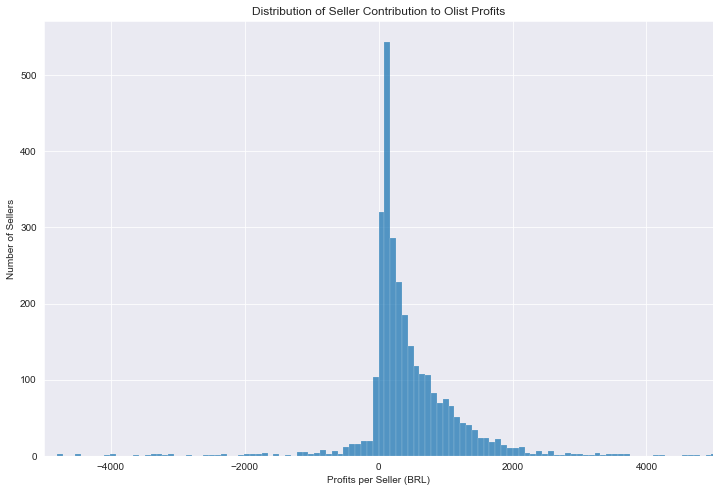

In [7]:
# Plot histogram of sellers' financial impact
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')

ax = sns.histplot(sellers.profit_per_seller)
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_xlabel('Profits per Seller (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Contribution to Olist Profits');

In [8]:
# Summary stats
sellers.profit_per_seller.describe()

count     2970.000000
mean       424.055631
std       1274.295160
min     -22419.517000
25%         93.000000
50%        285.790500
75%        720.593750
max      17967.605000
Name: profit_per_seller, dtype: float64

**Interpretation of Results**

From our histogram and summary stats of sellers' contribution to Olist profits, it appears as though the middle 50% of sellers on the platform generate anywhere from **93 to 721 BRL** (~17 to 134 USD) for Olist. We can also see a number of sellers with a negative impact on profits. 
 
Next, let's see if we can find out more about these sellers who are pulling down Olist profits. 

# Understanding the Impact of Poor-performing Sellers

To get a clearer picture of how much impact these poor-performing sellers have on Olist's profits, we'll break this question down into smaller pieces:

1. How many sellers have a negative impact on profits?
2. How much in total do these sellers affect Olist profits? 

### How many sellers are negatively impacting Olist profits?

Let's find the total number of poor-performing sellers, and also see what proportion they make up on the platform.

In [9]:
# Simple function to create column indicating whether sellers have positive or negative impact on profits
def olist_impact(x):
    if x < 0:
        return 'negative'
    else:
        return 'positive'

sellers['impact'] = sellers['profit_per_seller'].apply(olist_impact)
sellers[['impact','seller_id']].groupby('impact').count()

,seller_id
impact,
negative,276
positive,2694


In [10]:
# Total number of sellers
sellers.seller_id.count()

2970

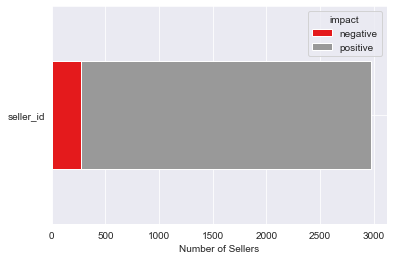

In [11]:
# Bar plot to visualize what proportion poor-performing sellers have
sellers[['impact','seller_id']].groupby('impact').count().transpose().plot.barh(stacked=True, cmap='Set1')
plt.xlabel('Number of Sellers');


In [12]:
# Proportion of poor-performing sellers
sellers[['impact']].value_counts(normalize=True)

impact  
positive    0.907071
negative    0.092929
dtype: float64

We can now see that there are **276 sellers** (or **roughly 9%** of all sellers) who negatively impact Olist profits. 

### How much do poor-performing sellers impact Olist profits?

To get a better picture of how much impact these sellers have on Olist's total profits, let's create a **whale curve** which will show us what percentage of sellers represent 'x' percentage of cumulative profits. 

To build our whale curve, we'll first sort our sellers from most to least profitable. Then we'll plot the cumulative profits from each additional seller to the platform.   

In [13]:
# Sort sellers by how much profit each contributes to Olist (from most to least)
sellers.sort_values('profit_per_seller', ignore_index=True, inplace=True, ascending=False)

# Calculate cumulative profits to Olist with each additional seller
sellers['cumulative_profits'] = sellers['profit_per_seller'].cumsum()
sellers.tail()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,4.069989,15620,943,1018,1.079533,17535.69,2553.569,-13066.431,negative,1335110.855
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,3.984307,20710,1146,1204,1.050611,37177.52,4757.752,-15952.248,negative,1319158.607
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,4.069222,30000,1706,1819,1.066237,104288.42,11948.842,-18051.158,negative,1301107.449
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,3.804610,40890,1806,2009,1.112403,200472.92,21647.292,-19242.708,negative,1281864.741
2969,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,19.0,0.127957,0.510215,3.922043,36270,1854,2039,1.099784,123304.83,13850.483,-22419.517,negative,1259445.224


In [14]:
# Total cumulative profits for Olist
total_profits = sellers['cumulative_profits'].iloc[-1]
total_profits

1259445.2239999846

In [15]:
# Calculate the cumulative percentage of profits represented by each additional seller
sellers['percent_profits'] = sellers['cumulative_profits'].div(total_profits).mul(100)

# Calculate the proportion of sellers represented (in percent)
sellers['seller_proportion'] = (sellers.index+1) / sellers.seller_id.count() * 100

whale_df = sellers[['seller_id', 'percent_profits', 'seller_proportion']]
whale_df.tail()

,seller_id,percent_profits,seller_proportion
2965,8b321bb669392f5163d04c59e235e066,106.007854,99.86532
2966,ea8482cd71df3c1969d7b9473ff13abc,104.741245,99.89899
2967,cc419e0650a3c5ba77189a1882b7556a,103.307982,99.93266
2968,4a3ca9315b744ce9f8e9374361493884,101.780111,99.96633
2969,6560211a19b47992c3666cc44a7e94c0,100.000000,100.00000


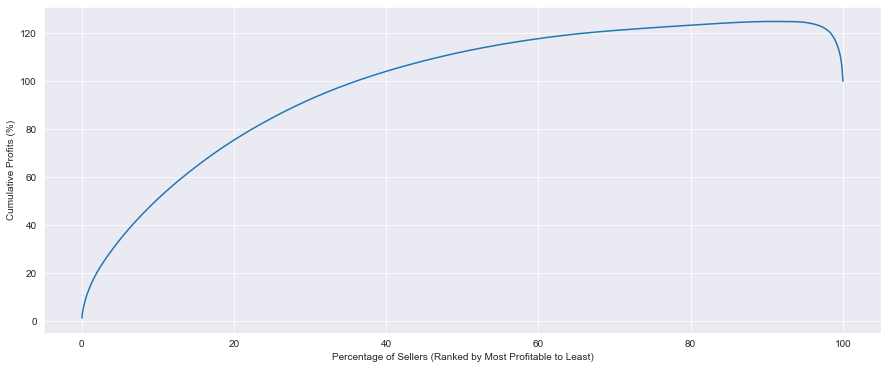

In [16]:
# Build our whale curve
plt.figure(figsize=(15,6))
sns.lineplot(data=sellers, x='seller_proportion', y='percent_profits')
plt.xlabel('Percentage of Sellers (Ranked by Most Profitable to Least)')
plt.ylabel('Cumulative Profits (%)');

Our whale curve helps to underscore that roughly 80% of our sellers contribute to 120% of Olist profits. Another 10% of sellers have a negligible impact. And, the **remaining 10% drag down profits by 20%**.  

Let's visualize this another way. What would Olist profits be if poor-performing sellers were no longer on the platform.

In [17]:
# Amount of reduction in profits due to bad reviews
neg_profits = sellers[sellers['impact']=='negative'].profit_per_seller.cumsum()
neg_profits.iloc[-1]

-313276.50200000097

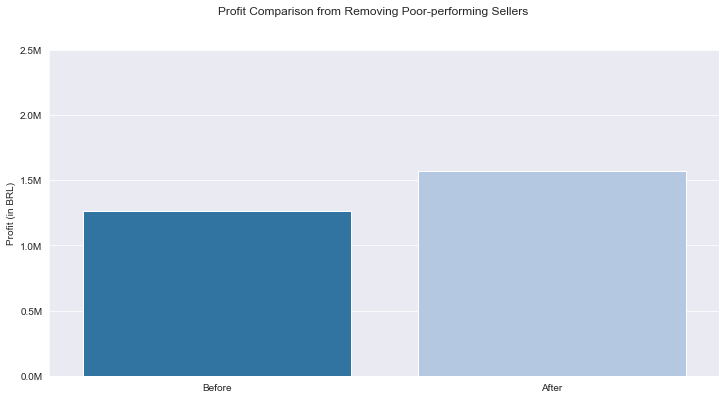

In [18]:
# Bar chart showing profit comparison after removal of poor-performing sellers

fig = plt.figure(figsize=(12,6))
x_values = ['Before', 'After']
y_values = [sellers.cumulative_profits.iloc[-1], sellers.cumulative_profits.iloc[-1] - neg_profits.iloc[-1]]
ax = sns.barplot(data=sellers, x=x_values, y=y_values, palette='tab20')

plt.ylabel('Profit (in BRL)')
plt.ylim(0, 2500000)
plt.suptitle('Profit Comparison from Removing Poor-performing Sellers', fontsize=12)
ax.set_yticks(ax.get_yticks())
yticklabels=['{:3.1f}'.format(y) + 'M' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(yticklabels);

If Olist were to drop sellers who had a negative impact on profits, the platform would see an immediate boost in profits of **313,277 BRL** ($58,246 USD)! 

## What's the impact if we factor in IT costs?

FROM PROBLEM STATEMENT --REMOVE

In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).
For the sake of simplicity, we will consider Olist’s total cumulative IT Costs to be proportional to the square-root of the total cumulative number of orders approved.
#The IT department also told you that since the birth of the marketplace, cumulative IT costs have amounted to 500,000 BRL.

In [19]:
sellers.tail()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,...,943,1018,1.079533,17535.69,2553.569,-13066.431,negative,1335110.855,106.007854,99.86532
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,...,1146,1204,1.050611,37177.52,4757.752,-15952.248,negative,1319158.607,104.741245,99.89899
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,...,1706,1819,1.066237,104288.42,11948.842,-18051.158,negative,1301107.449,103.307982,99.93266
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,...,1806,2009,1.112403,200472.92,21647.292,-19242.708,negative,1281864.741,101.780111,99.96633
2969,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,19.0,0.127957,0.510215,...,1854,2039,1.099784,123304.83,13850.483,-22419.517,negative,1259445.224,100.000000,100.00000


While it does appear now that Olist's profit margins would benefit from removing poor-performing sellers, we've been asked to examine how removal of these sellers might also impact Olist's IT costs (servers, etc.). 

Olist's IT costs increase with the number of orders processed, but does so less and less rapidly due to scale effects. More precisely, we've been told that **IT costs are proportional to the square-root of cumulative number of orders**. Additionally, the IT department has reported accumulated IT costs of **500,000 BRL** (~92,930 USD) since the founding of the company.

Let's approach this using the following steps: 

1. Calculate the amount of IT costs for any given order volume. 
2. Calculate the order volume of poor-performing sellers and the accompanying IT costs 
3. Compare the difference in IT costs from removing poor-performing sellers

### What are the IT costs for a particular order volume?

We've been provided information that IT costs are proportional to the square-root of the number of approved orders:

**Olist IT costs = $k\sqrt{n}$**

Here ***n*** is the ***total number of approved orders*** and ***k*** is a ***proportionality constant***.

Given this IT cost curve, we can see that it should take on the shape of a concave ascending curve like $ y = \sqrt{x} $ but also transformed by a proportionality constant *k*. Let's plot a generic $ y = \sqrt{x} $ to help visualize.

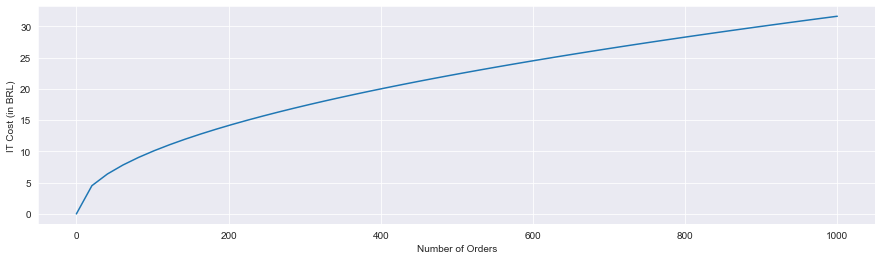

In [83]:
# Plot of a generic y = x**(1/2) curve

plt.figure(figsize=(15,4))
x=np.linspace(0,1000, 50)
y=x**0.5
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost (in BRL)');

Given the shape of this particular cost curve, we can already see that IT costs will steadily increase with more orders. However, the difference in IT cost between each additional order (marginal IT cost) is the greatest early on (when order numbers are low). At higher order volume, the IT cost appears to change less and less rapidly. 

Let's now try to get a more precise curve by doing a little math to solve for the proportionality constant *k*. 

Since we've been told that the cumulative cost of IT to date is **500,000 BRL**, we can set this equal to the area under the curve bounded by 0 to the *current number of orders* ***n***.

Then to calculate the proportionality constant *k*, we just need to take the definite integral of this expression.



$\int_{0}^{n} k\sqrt{n}$ = 500,000    

where *n* is the number of orders and *k* is a proportionality constant

In [21]:
# total of n_orders
total_orders = sellers.n_orders.sum()
total_orders

99844

Let's evaluate the integral from **0** orders to the total cumulative number of orders **99,844**. 

**$\int_{0}^{n} k\sqrt{n} \to \int_{0}^{99,844} k(\frac{2}{3}) n^\frac{3}{2} - k(\frac{2}{3}) (0)^\frac{3}{2} $**

Setting this equal to 500,000, we can solve for the proportionality constant ***k***.

**$ k(\frac{2}{3}) (99,844)^\frac{3}{2} = 500,000 $**

In [22]:
# Evaluating integral and solving for proportionatity constant k
k = 500000 / ((2/3)*(99844**1.5))
k

0.023772688842554592

This gives us the proportionality constant **k** $\approx$ **0.024**. Now let's re-plot our IT cost curve more precisely.

$ y = \hspace{0.25 cm} k \sqrt{n}  \hspace{0.25 cm} = 0.024\sqrt{n} $

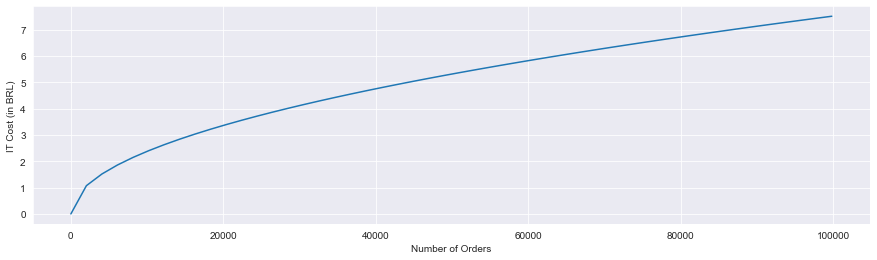

In [23]:
# Re-Plotting our IT Cost Curve more precisely

plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 50)
y=(k)*(x**0.5)
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost (in BRL)');

We can now see what the IT cost will be at a particular order volume. The slope of the curve starts to stabilize once you approach 20,000 orders telling us that benefits from scale effects will start to matter less for IT costs. As the IT costs becomes more linear in shape, it means that more orders will just increase IT costs at a constant rate. 

### IT Costs Associated with Specific Sellers

Let's now examine the IT costs associated with specific sellers. Since IT costs are a function of order volume, we'll also see if there are differences between our good and poor-performing sellers.  

In [24]:
# Calculating IT costs per additional seller on the platform 

# The cumulative total of orders on the platform after adding this seller
sellers['cumulative_orders'] = sellers['n_orders'].cumsum()

# The cumulative total IT cost for Olist after adding this seller
sellers['cumulative_it_cost'] = k*(2/3)*(sellers['cumulative_orders']**1.5)

sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion,cumulative_orders,cumulative_it_cost
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.097765,0.558659,...,1.145251,222776.05,23237.605,17967.605,positive,17967.605,1.426629,0.03367,358,107.352358
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,22.0,0.104167,0.627976,...,1.011905,176431.87,19403.187,14603.187,positive,32570.792,2.586122,0.06734,694,289.751873
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.088889,0.673504,...,1.001709,194042.03,21004.203,14254.203,positive,46824.995,3.717906,0.10101,1279,724.924643
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,1.054217,79284.55,8808.455,7288.455,positive,54113.450,4.296610,0.13468,1445,870.540173
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,1.026738,74004.62,9000.462,6780.462,positive,60893.912,4.834979,0.16835,1632,1044.882074


### Order Volume

Since IT costs are driven by order volume, let's see if there is a difference for these two groups of sellers.

In [25]:
# Calculate the order volume for each group of sellers
order_vol_df = sellers[['n_orders','impact']].groupby('impact').sum()
order_vol_df

,n_orders
impact,
negative,39817
positive,60027


In [26]:
# # Calculate the number of orders from poor-performing sellers
# bad_seller_volume = total_orders - sellers[sellers['impact']=='negative']['cumulative_orders'].iat[0]
# bad_seller_volume

In [27]:
# # Calculate the number of orders from good sellers
# good_seller_volume = total_orders - bad_seller_volume
# good_seller_volume

In [28]:
order_vol_df.transpose()

impact,negative,positive
n_orders,39817,60027


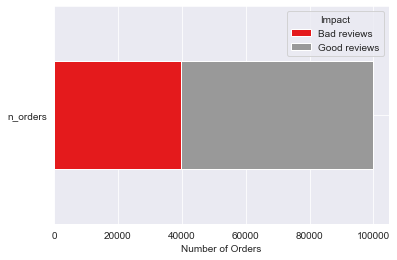

In [29]:
order_vol_df.transpose().plot.barh(stacked=True, cmap='Set1')
plt.legend(title='Impact', labels=['Bad reviews', 'Good reviews'])
plt.xlabel('Number of Orders');

We now see that poor-performing sellers have about 40% of the order volume on Olist but make up only 9% of sellers. This already tells us that they are contributing to a larger share of the IT cost burden for Olist.

Let's find out what the average difference in order volume is for these two groups.

In [41]:
# Calculate average order volume for each group of sellers
avg_order_vol = sellers[['n_orders','impact']].groupby('impact').mean()

avg_order_vol.transpose()


impact,negative,positive
n_orders,144.264493,22.281737


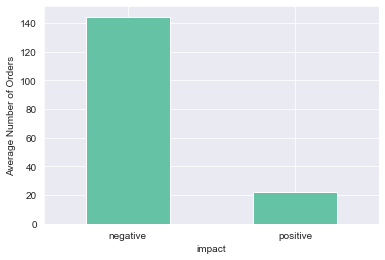

In [43]:
avg_order_vol.plot(kind='bar', cmap='Set2', ylabel='Average Number of Orders', rot=0, legend=False);

We can see that poor-performing sellers have an average order volume of roughly **7x** more than other sellers. This underscores their heavy usage of the IT infrastructure and extra IT cost burden.



Let's now see what the total and average IT cost would be for Olist if poor-performing sellers were to be removed.



In [33]:
# Total Cumulative IT Cost with poor performers removed
it_cost_post_removal = 0.024*(2/3)*((60028)**1.5)
it_cost_post_removal

235315.64022040632

In [47]:
# Average IT cost per order with poor performers removed
it_cost_post_removal / order_vol_df.iloc[1]

n_orders    3.920163
Name: positive, dtype: float64

Let's now compare both total and average IT costs if we were to remove poor-performing sellers from the platform.



In [60]:
total_it_cost = sellers[['impact', 'cumulative_it_cost']].groupby('impact').max().transpose()
total_it_cost

impact,negative,positive
cumulative_it_cost,500000.0,233081.071184


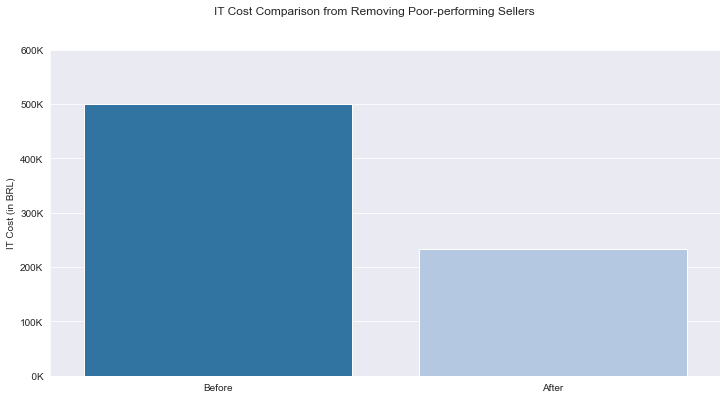

In [79]:
# Total Cumulative IT Costs before and after removing poor performers

fig = plt.figure(figsize=(12,6))
x_values = ['Before', 'After']
y_values = [total_it_cost.iloc[0,0], total_it_cost.iloc[0,1]]
ax = sns.barplot(data=sellers, x=x_values, y=y_values, palette='tab20')

plt.ylabel('IT Cost (in BRL)')
plt.ylim(0, 600000)
plt.suptitle('IT Cost Comparison from Removing Poor-performing Sellers', fontsize=12)
ax.set_yticks(ax.get_yticks())
yticklabels=['{:3.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
ax.set_yticklabels(yticklabels);

In [80]:
# Calculation of reduction of total IT costs from removing poor-performing sellers
total_it_cost.iloc[0,0] - total_it_cost.iloc[0,1]

266918.9288156275

Removing poor-performing sellers from the platform reduces order volume by 40% and translates into a reduction of **266,919 BRL** (~50,868 USD) in IT costs.

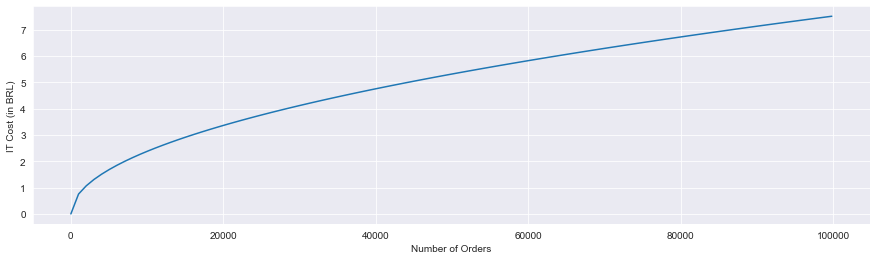

In [121]:
# Our IT Cost Curve

plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 100)
y=(k)*(x**0.5)
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost (in BRL)');

As we can already see from the shape of the IT Cost Curve, the greatest difference in marginal IT cost occurs at very low order volume. 

In [ ]:
# order volume if removed 60,027 

To verify this more precisely, we can return to our IT Cost Curve. The additional cost in IT for each additional order (the marginal IT cost) is essentially the slope of the IT Cost Curve at a specific order volume. 

To arrive at this slope, we can simply take the first derivative of our IT Cost Curve:   
$ f(n) = 0.024\sqrt{n}  \to f\prime(n) = 0.012 (n)^-\frac{1}{2} $

By removing poor-performing sellers from Olist, the order volume would drop from **99,844** to **60,027** orders. However, if we evaluate the marginal IT cost at both of these amounts, we can confirm that the difference in marginal cost is quite small (0.000049 vs. 0.000038). 

Since most of the change in slope for the IT Cost Curve has already already occurred at a lower order volume (more near the range of 10,000 orders), the change in order volume brought about by the removal of poor-performing sellers would have negligible impact on marginal IT Costs. 


In [155]:
# Let's calculate the Marginal IT Cost for specific order volume

order_volume = pd.DataFrame(np.arange(1, total_orders+1))

marg_it_cost = 0.012*(order_volume)**-0.5

i_compare =[60027,99843]

marg_it_cost.iloc[i_compare] 



,0
60027,0.000049
99843,0.000038


In [123]:
# Let's find out where marginal IT costs would be the greatest  

order_volume = pd.DataFrame(np.arange(1, total_orders+1))


# Marginal IT Cost
marg_it_cost = 0.012*(order_volume)**-0.5
marg_it_cost.iloc[66027]


0    0.000047
Name: 66027, dtype: float64

In [130]:
# IT Cost 

it_cost = 0.024*(order_volume)**0.5
it_cost.iloc[66027:66029].diff()


,0
66027,NaN
66028,0.000047


In [131]:
it_cost.iloc[99842:99844].diff()

,0
99842,NaN
99843,0.000038


In [134]:
it_cost.iloc[100:130]

,0
100,0.241197
101,0.242388
102,0.243573
103,0.244753
104,0.245927
105,0.247095
106,0.248258
107,0.249415
108,0.250567
109,0.251714


In [84]:
# The average cost of IT per order after adding this seller
#sellers['it_unit_cost'] = sellers.cumulative_it_cost / sellers.cumulative_orders

# The IT cost for Olist after adding this seller
sellers['it_cost'] = k*sellers['cumulative_orders']**0.5

# # Difference between average and marginal IT cost
# sellers['diff_unit_marg_it'] = sellers.it_unit_cost - sellers.it_marg_cost
#sellers['diff_unit_marg_it'].abs().min()


sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion,cumulative_orders,cumulative_it_cost
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.097765,0.558659,...,1.145251,222776.05,23237.605,17967.605,positive,17967.605,1.426629,0.03367,358,107.352358
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,22.0,0.104167,0.627976,...,1.011905,176431.87,19403.187,14603.187,positive,32570.792,2.586122,0.06734,694,289.751873
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.088889,0.673504,...,1.001709,194042.03,21004.203,14254.203,positive,46824.995,3.717906,0.10101,1279,724.924643
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,1.054217,79284.55,8808.455,7288.455,positive,54113.450,4.296610,0.13468,1445,870.540173
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,1.026738,74004.62,9000.462,6780.462,positive,60893.912,4.834979,0.16835,1632,1044.882074


----NOT SURE WHERE TO PUT YET
Understanding this will help us gauge whether removing the poorest-performing sellers along with their order volume would adversely impact Olist's cost structure. 

Sellers with high order volume also have accompanying higher IT costs associated with them. If poor-performing sellers both pose a drag on profits from the effects of bad reviews, and additionally, with large order volume consume a larger of IT resources, then it becomes even clearer that removal of these sellers would improve profits and relieve the burden on the IT infrastructure.  

# Recommendation: 

## Remove poorest performing sellers on Olist platform for immediate profit increase

**Recommendation to CEO:**

In the short term, we believe that Olist can improve profits and overall customer satisfaction by removing poor-performing sellers.

Our preliminary analysis shows that removing these sellers from the platform will immediately increase Olist profits by reducing costs on two fronts:

1. **Costs Associated with Bad Reviews** - removal of sellers who have received enough bad reviews to have a drag on Olist margins will **boost profits by 20%** amounting to an increase of **313,277 BRL** ($58,246 USD).

2. **IT Costs** - IT costs are a function of overall order volume, and since poor-performing sellers have been found to have a disproportionately large order volume, their removal translates into an overall **40% reduction in IT costs** amounting to a savings of **266,919 BRL** (~50,868 USD). 

In sum, by removing poor-performing sellers from the platform, Olist stands to see an immediate gain of **580,196 BRL** (~110,484 USD) to its financial performance. Additionally, we would expect to see an overall improvement in brand reputation as average customer satisfaction increases.

**Caveats**

These findings have been made based on assumptions for the monetary costs associated with bad reviews as well as the model for IT infrastructure costs.

**Other Areas For Further Analysis**

A more fine-toothed analysis for identifying poor-performing sellers might also review sellers who have only just recently joined the platform and not gained enough experience to properly use the platform properly or engage with customers. With sufficient support, they may potentially become strong performing sellers and advocates for the platform that has a good on-ramping process and support system for new sellers.     

If expanding to a long-term strategy



## Profit Analysis

- 280 poorest-performing sellers have negative impact on profits
- Top 100 highest performing sellers comprise bulk of profits

## Areas to Explore Further

- Evaluate whether can improve average seller performance
- Explore reviews for cause of dissatisfaction